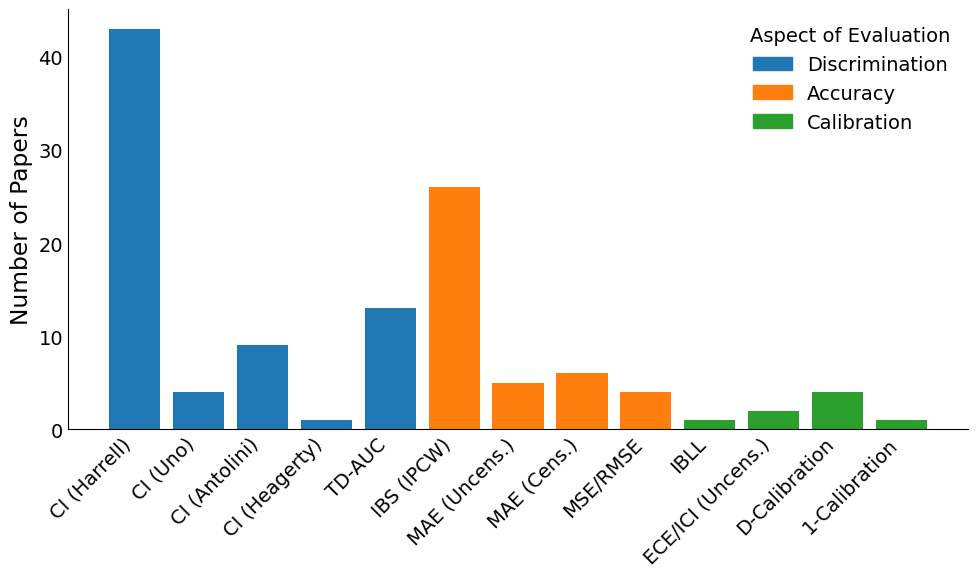

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

matplotlib_style = 'default'
plt.style.use(matplotlib_style)
plt.rcParams.update({
    'axes.labelsize': 'large',
    'axes.titlesize': 'large',
    'font.size': 14.0,
    'legend.fontsize': 'medium'
})

# Load data
df = pd.read_csv('data.csv')

# Count non-empty values per metric (excluding the title column)
metric_counts = df.iloc[:, 1:].apply(lambda col: col.notna() & (col != ''), axis=0).sum()

# Create the new combined metric 'MAE (Cens.)'
mae_cens_sum = metric_counts.get("MAE (Hinge)", 0) + metric_counts.get("MAE (Margin)", 0) + metric_counts.get("MAE (PO)", 0)

# Remove the three original MAE metrics
metric_counts = metric_counts.drop(["MAE (Hinge)", "MAE (Margin)", "MAE (PO)"], errors='ignore')

# Add the combined metric
metric_counts["MAE (Cens.)"] = mae_cens_sum

# Define categories with the new combined metric instead of the three separate ones
categories = {
    "Discrimination": ["CI (Harrell)", "CI (Uno)", "CI (Antolini)", "CI (Heagerty)", "TD-AUC"],
    "Accuracy": ["IBS (IPCW)", "MAE (Uncens.)", "MAE (Cens.)", "MSE/RMSE"],
    "Calibration": ["IBLL", "ECE/ICI (Uncens.)", "D-Calibration", "1-Calibration"]
}

# Define category colors
category_colors = {
    "Discrimination": "tab:blue",
    "Accuracy": "tab:orange",
    "Calibration": "tab:green"
}

# Flatten to map each metric to its category and color
metric_to_category = {metric: cat for cat, metrics in categories.items() for metric in metrics}
metric_to_color = {metric: category_colors[metric_to_category[metric]] for metric in metric_counts.index if metric in metric_to_category}

# Sort metrics by category for grouped plotting
sorted_metrics = sum(categories.values(), [])

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    sorted_metrics,
    [metric_counts.get(m, 0) for m in sorted_metrics],
    color=[metric_to_color.get(m, "gray") for m in sorted_metrics]
)

# Remove plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend handles (category color blocks)
legend_handles = [Patch(color=color, label=cat) for cat, color in category_colors.items()]
plt.legend(handles=legend_handles, title="Aspect of Evaluation", frameon=False)

# Labeling
plt.ylabel("Number of Papers")
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0)
plt.tight_layout()
plt.savefig("metrics.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [2]:
metric_counts

CI (Harrell)         43
CI (Uno)              4
CI (Antolini)         9
CI (Heagerty)         1
IBS (IPCW)           26
MSE/RMSE              4
MAE (Uncens.)         5
IBLL                  1
TD-AUC               13
1-Calibration         1
ECE/ICI (Uncens.)     2
D-Calibration         4
MAE (Cens.)           6
dtype: int64